Training on single band environment...


  1%|          | 3/500 [00:00<00:19, 24.86it/s]

Episode: 0, Reward: 140, Exploration rate: 0.9950


 21%|██        | 105/500 [00:04<00:13, 28.51it/s]

Episode: 100, Reward: 500, Exploration rate: 0.6027


 41%|████      | 204/500 [00:07<00:10, 28.16it/s]

Episode: 200, Reward: 530, Exploration rate: 0.3651


 61%|██████    | 306/500 [00:11<00:06, 27.74it/s]

Episode: 300, Reward: 635, Exploration rate: 0.2212


 81%|████████  | 404/500 [00:14<00:03, 27.59it/s]

Episode: 400, Reward: 650, Exploration rate: 0.1340


100%|██████████| 100/100 [00:02<00:00, 36.88it/s]


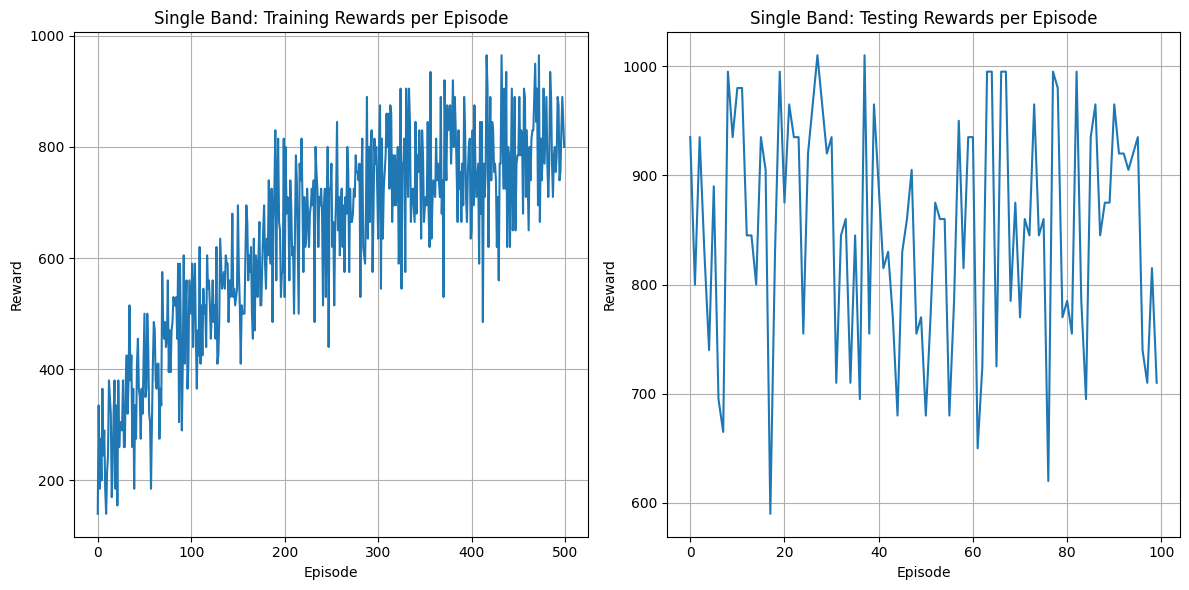

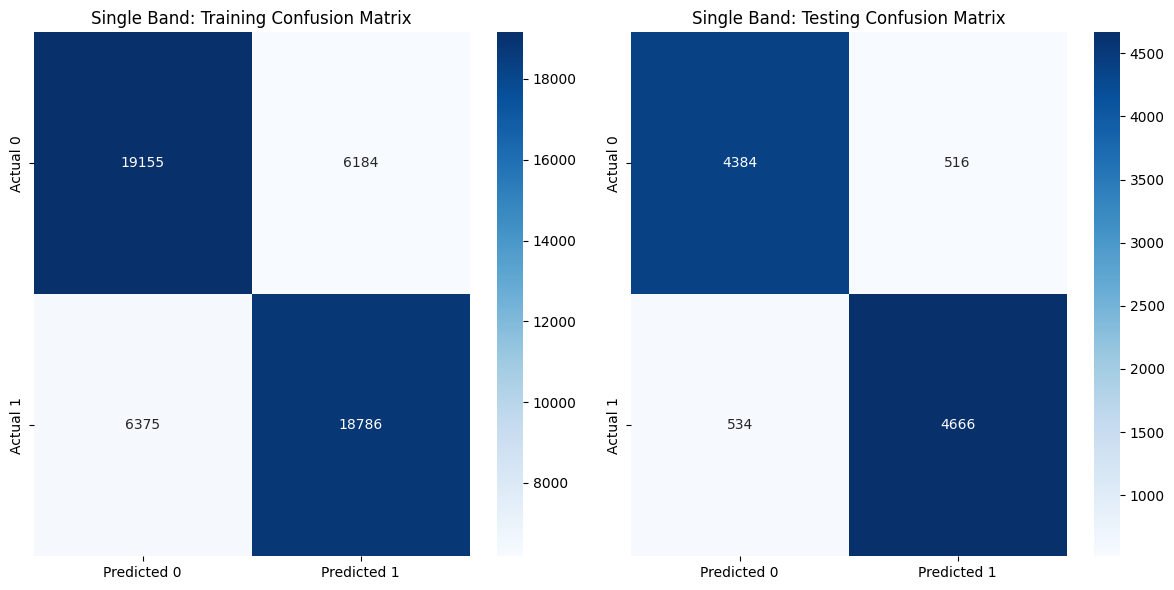

ValueError: Found input variables with inconsistent numbers of samples: [50500, 50000]

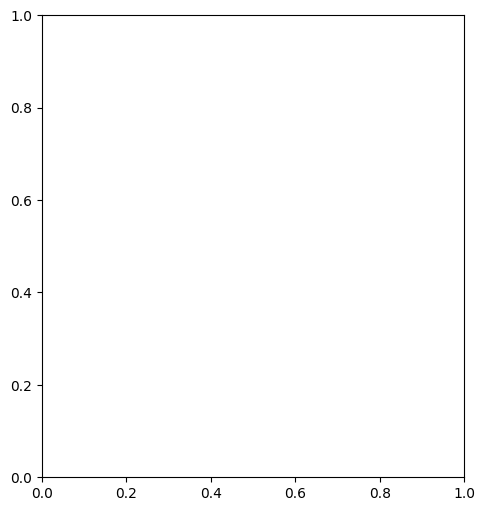

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
from environments import SBEOS_Environment
from tqdm import tqdm

class QLearningAgent:
    def __init__(self, state_size, action_size, learning_rate=0.1, discount_factor=0.95, 
                 exploration_rate=1.0, exploration_decay=0.995, min_exploration_rate=0.01):
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration_rate = min_exploration_rate
        
        # Initialize Q-table
        # We need to discretize the continuous state space first
        self.n_bins = 10  # Number of bins for each dimension
        self.q_table = {}
        
    def discretize_state(self, state):
        """Convert continuous state to discrete state for Q-table lookup"""
        # For simplicity, we'll use a basic binning approach
        discretized = []
        for value in state:
            # Clip to reasonable range and discretize
            bin_value = min(int(np.clip(value * self.n_bins, 0, self.n_bins - 1)), self.n_bins - 1)
            discretized.append(bin_value)
        return tuple(discretized)
    
    def get_action(self, state):
        """Select action using epsilon-greedy policy"""
        discretized_state = self.discretize_state(state)
        
        if np.random.random() < self.exploration_rate:
            # Explore: select random action
            return np.random.randint(self.action_size)
        else:
            # Exploit: select best action from Q-table
            if discretized_state not in self.q_table:
                self.q_table[discretized_state] = np.zeros(self.action_size)
            return np.argmax(self.q_table[discretized_state])
    
    def update_q_table(self, state, action, reward, next_state, done):
        """Update Q-table using Q-learning update rule"""
        discretized_state = self.discretize_state(state)
        discretized_next_state = self.discretize_state(next_state)
        
        # Initialize Q-values for states if they don't exist
        if discretized_state not in self.q_table:
            self.q_table[discretized_state] = np.zeros(self.action_size)
        if discretized_next_state not in self.q_table:
            self.q_table[discretized_next_state] = np.zeros(self.action_size)
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[discretized_next_state])
        td_target = reward + (0 if done else self.discount_factor * self.q_table[discretized_next_state][best_next_action])
        td_error = td_target - self.q_table[discretized_state][action]
        
        self.q_table[discretized_state][action] += self.learning_rate * td_error
        
    def decay_exploration_rate(self):
        """Decay exploration rate"""
        self.exploration_rate = max(self.min_exploration_rate, 
                                    self.exploration_rate * self.exploration_decay)

def train_q_learning(env, episodes=1000, is_multiband=False):
    """Train Q-learning agent on SBEOS environment"""
    # Initialize Q-learning agent
    state_size = env.window_size + 6  # Based on observation space
    
    if is_multiband:
        # For multiband, the observation includes features for each band
        state_size = (env.window_size + 6) * env.num_bands
        action_size = env.num_bands * 4  # 4 actions per band
    else:
        # For single band
        action_size = 4  # 0: predict 0, 1: predict 1, 2: predict 0 with high energy, 3: predict 1 with high energy
    
    agent = QLearningAgent(state_size, action_size)
    
    # Track metrics
    all_rewards = []
    episode_rewards = []
    true_states = []
    predicted_states = []
    
    # Training loop
    for episode in tqdm(range(episodes)):
        state = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # Select action
            action = agent.get_action(state)
            
            # Take action
            next_state, reward, done, info = env.step(action)
            
            # Update Q-table
            agent.update_q_table(state, action, reward, next_state, done)
            
            # Track metrics
            episode_reward += reward
            true_state = info["state"]
            predicted_state = action % 2  # Extract the binary prediction (0 or 1)
            
            true_states.append(true_state)
            predicted_states.append(predicted_state)
            
            # Update state
            state = next_state
        
        # Decay exploration rate
        agent.decay_exploration_rate()
        
        # Track episode rewards
        episode_rewards.append(episode_reward)
        all_rewards.extend([reward] * env.max_timesteps)
        
        if episode % 100 == 0:
            print(f"Episode: {episode}, Reward: {episode_reward}, Exploration rate: {agent.exploration_rate:.4f}")
    
    return agent, {
        'episode_rewards': episode_rewards,
        'all_rewards': all_rewards,
        'true_states': true_states,
        'predicted_states': predicted_states
    }

def test_q_learning(env, agent, episodes=100, is_multiband=False):
    """Test trained Q-learning agent"""
    # Track metrics
    episode_rewards = []
    true_states = []
    predicted_states = []
    action_values = []  # Store action values for ROC curve
    
    # Testing loop
    for episode in tqdm(range(episodes)):
        state = env.reset()
        done = False
        episode_reward = 0
        
        while not done:
            # Select best action (no exploration)
            discretized_state = agent.discretize_state(state)
            if discretized_state not in agent.q_table:
                agent.q_table[discretized_state] = np.zeros(agent.action_size)
            
            # Get Q-values for this state
            q_values = agent.q_table[discretized_state]
            action = np.argmax(q_values)
            
            # For ROC curve, get the difference between Q-values for predicting 0 vs 1
            if is_multiband:
                band_idx = action // 4
                base_action_idx = action % 4
                # Compare the max Q-value of predicting 0 vs predicting 1 for this band
                action_0_idx = band_idx * 4 + 0
                action_1_idx = band_idx * 4 + 1
                if action_0_idx < len(q_values) and action_1_idx < len(q_values):
                    action_value = q_values[action_1_idx] - q_values[action_0_idx]
                else:
                    action_value = 0
            else:
                # Compare Q-values for action 0 (predict 0) vs action 1 (predict 1)
                action_value = q_values[1] - q_values[0]
            
            # Take action
            next_state, reward, done, info = env.step(action)
            
            # Track metrics
            episode_reward += reward
            true_state = info["state"]
            predicted_state = action % 2  # Extract the binary prediction (0 or 1)
            
            true_states.append(true_state)
            predicted_states.append(predicted_state)
            action_values.append(action_value)
            
            # Update state
            state = next_state
        
        # Track episode rewards
        episode_rewards.append(episode_reward)
    
    return {
        'episode_rewards': episode_rewards,
        'true_states': true_states,
        'predicted_states': predicted_states,
        'action_values': action_values
    }

def plot_rewards(train_metrics, test_metrics, title_prefix=""):
    """Plot episode rewards for training and testing"""
    plt.figure(figsize=(12, 6))
    
    # Plot training rewards
    plt.subplot(1, 2, 1)
    plt.plot(train_metrics['episode_rewards'])
    plt.title(f'{title_prefix}Training Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    
    # Plot testing rewards
    plt.subplot(1, 2, 2)
    plt.plot(test_metrics['episode_rewards'])
    plt.title(f'{title_prefix}Testing Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(train_metrics, test_metrics, title_prefix=""):
    """Plot confusion matrices for training and testing"""
    plt.figure(figsize=(12, 6))
    
    # Training confusion matrix
    plt.subplot(1, 2, 1)
    train_cm = confusion_matrix(train_metrics['true_states'], train_metrics['predicted_states'])
    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{title_prefix}Training Confusion Matrix')
    
    # Testing confusion matrix
    plt.subplot(1, 2, 2)
    test_cm = confusion_matrix(test_metrics['true_states'], test_metrics['predicted_states'])
    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'])
    plt.title(f'{title_prefix}Testing Confusion Matrix')
    
    plt.tight_layout()
    plt.show()

def plot_roc_curves(train_metrics, test_metrics, title_prefix=""):
    """Plot ROC curves for training and testing"""
    plt.figure(figsize=(12, 6))
    
    # Training ROC curve
    plt.subplot(1, 2, 1)
    train_action_values = np.array(train_metrics['all_rewards'])[:len(train_metrics['true_states'])]
    train_fpr, train_tpr, _ = roc_curve(train_metrics['true_states'], train_action_values)
    train_roc_auc = auc(train_fpr, train_tpr)
    plt.plot(train_fpr, train_tpr, label=f'ROC curve (area = {train_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}Training ROC Curve')
    plt.legend(loc="lower right")
    
    # Testing ROC curve
    plt.subplot(1, 2, 2)
    test_fpr, test_tpr, _ = roc_curve(test_metrics['true_states'], test_metrics['action_values'])
    test_roc_auc = auc(test_fpr, test_tpr)
    plt.plot(test_fpr, test_tpr, label=f'ROC curve (area = {test_roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title_prefix}Testing ROC Curve')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Create single band environment
    print("Training on single band environment...")
    single_env = SBEOS_Environment(max_timesteps=100)
    single_agent, single_train_metrics = train_q_learning(single_env, episodes=500)
    single_test_metrics = test_q_learning(single_env, single_agent, episodes=100)
    
    # Plot metrics for single band
    plot_rewards(single_train_metrics, single_test_metrics, "Single Band: ")
    plot_confusion_matrices(single_train_metrics, single_test_metrics, "Single Band: ")
    plot_roc_curves(single_train_metrics, single_test_metrics, "Single Band: ")
    

In [ ]:
import sys
import os
from environments import SBEOS_Environment, MultiBandSBEOS
# from QLearningAgent import train_q_learning, test_q_learning, plot_rewards, plot_confusion_matrices, plot_roc_curves
import numpy as np
import matplotlib.pyplot as plt
import time

def main():
    # Set random seed for reproducibility
    np.random.seed(42)
    
    # Parameters
    training_episodes = 300  # Reduced for faster execution
    testing_episodes = 50
    timesteps = 120
    
    # Create output directory for plots
    os.makedirs("plots", exist_ok=True)
    
    print("Starting SBEOS Q-Learning experiments")
    
    # Single band experiment
    print("\n==== Single Band SBEOS Environment ====")
    single_env = SBEOS_Environment(max_timesteps=timesteps)
    
    start_time = time.time()
    print(f"Training Q-learning agent for {training_episodes} episodes...")
    single_agent, single_train_metrics = train_q_learning(
        single_env, episodes=training_episodes, is_multiband=False
    )
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    
    print(f"Testing Q-learning agent for {testing_episodes} episodes...")
    single_test_metrics = test_q_learning(
        single_env, single_agent, episodes=testing_episodes, is_multiband=False
    )
    
    # Generate plots for single band
    print("Generating single band plots...")
    
    # Reward plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(single_train_metrics['episode_rewards'])
    plt.title('Single Band: Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(single_test_metrics['episode_rewards'])
    plt.title('Single Band: Testing Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("plots/single_band_rewards.png")
    
    # Confusion matrices
    plot_confusion_matrices(single_train_metrics, single_test_metrics, "Single Band: ")
    plt.savefig("plots/single_band_confusion_matrices.png")
    
    # ROC curves
    plot_roc_curves(single_train_metrics, single_test_metrics, "Single Band: ")
    plt.savefig("plots/single_band_roc_curves.png")
    
    # Multi-band experiment
    print("\n==== Multi-Band SBEOS Environment (2 bands) ====")
    multi_env = MultiBandSBEOS(num_bands=2, max_timesteps=timesteps)
    
    start_time = time.time()
    print(f"Training Q-learning agent for {training_episodes} episodes...")
    multi_agent, multi_train_metrics = train_q_learning(
        multi_env, episodes=training_episodes, is_multiband=True
    )
    print(f"Training completed in {time.time() - start_time:.2f} seconds")
    
    print(f"Testing Q-learning agent for {testing_episodes} episodes...")
    multi_test_metrics = test_q_learning(
        multi_env, multi_agent, episodes=testing_episodes, is_multiband=True
    )
    
    # Generate plots for multi band
    print("Generating multi-band plots...")
    
    # Reward plots
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(multi_train_metrics['episode_rewards'])
    plt.title('Multi-Band: Training Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(multi_test_metrics['episode_rewards'])
    plt.title('Multi-Band: Testing Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig("plots/multi_band_rewards.png")
    
    # Confusion matrices
    plot_confusion_matrices(multi_train_metrics, multi_test_metrics, "Multi-Band: ")
    plt.savefig("plots/multi_band_confusion_matrices.png")
    
    # ROC curves
    plot_roc_curves(multi_train_metrics, multi_test_metrics, "Multi-Band: ")
    plt.savefig("plots/multi_band_roc_curves.png")
    
    print("\nExperiments completed. Plots saved in 'plots' directory.")

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'paste'